In [1]:
import pandas as pd
import numpy as np
import cv2 as cv

import seaborn as sns
import matplotlib.pyplot as plt

from skimage.restoration import denoise_tv_chambolle
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

from functions_dl import *

---
# 1. Import des donnnées

In [2]:
# Paramètrage
n_breeds = 5
size_image = 'original'

In [3]:
if size_image == 'original':
    dogs_raw = pd.read_csv('src/dogs.csv')
elif size_image == '220px':
    dogs_raw = pd.read_csv('src/dogs220.csv')

dogs_raw

,uri,breeds
0,src\img\n02085620-Chihuahua\n02085620_10074.jpg,Chihuahua
1,src\img\n02085620-Chihuahua\n02085620_10131.jpg,Chihuahua
2,src\img\n02085620-Chihuahua\n02085620_10621.jpg,Chihuahua
3,src\img\n02085620-Chihuahua\n02085620_1073.jpg,Chihuahua
4,src\img\n02085620-Chihuahua\n02085620_10976.jpg,Chihuahua
...,...,...
20574,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20575,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20576,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20577,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog


In [4]:
print(f'Nous avons {len(dogs_raw)} photos de chiens comprenant {dogs_raw.breeds.nunique()} races.')

Nous avons 20579 photos de chiens comprenant 120 races.


---
# 2. Réduction des données aux nombres de races testées

In [5]:
top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
top_breeds

[&#39;Maltese_dog&#39;, &#39;Afghan_hound&#39;, &#39;Scottish_deerhound&#39;, &#39;Pomeranian&#39;, &#39;Samoyed&#39;]

In [7]:
dogs = pd.DataFrame()
for b in top_breeds:
    dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

dogs

,uri,breeds
337,src\img\n02085936-Maltese_dog\n02085936_10073.jpg,Maltese_dog
338,src\img\n02085936-Maltese_dog\n02085936_10130.jpg,Maltese_dog
339,src\img\n02085936-Maltese_dog\n02085936_10148.jpg,Maltese_dog
340,src\img\n02085936-Maltese_dog\n02085936_10197.jpg,Maltese_dog
341,src\img\n02085936-Maltese_dog\n02085936_10199.jpg,Maltese_dog
...,...,...
18417,src\img\n02111889-Samoyed\n02111889_899.jpg,Samoyed
18418,src\img\n02111889-Samoyed\n02111889_9001.jpg,Samoyed
18419,src\img\n02111889-Samoyed\n02111889_91.jpg,Samoyed
18420,src\img\n02111889-Samoyed\n02111889_928.jpg,Samoyed


In [8]:
# Encodage des données cibles
le = LabelEncoder()
dogs['encoding_breeds'] = le.fit_transform(dogs.breeds)
dogs

,uri,breeds,encoding_breeds
337,src\img\n02085936-Maltese_dog\n02085936_10073.jpg,Maltese_dog,1
338,src\img\n02085936-Maltese_dog\n02085936_10130.jpg,Maltese_dog,1
339,src\img\n02085936-Maltese_dog\n02085936_10148.jpg,Maltese_dog,1
340,src\img\n02085936-Maltese_dog\n02085936_10197.jpg,Maltese_dog,1
341,src\img\n02085936-Maltese_dog\n02085936_10199.jpg,Maltese_dog,1
...,...,...,...
18417,src\img\n02111889-Samoyed\n02111889_899.jpg,Samoyed,3
18418,src\img\n02111889-Samoyed\n02111889_9001.jpg,Samoyed,3
18419,src\img\n02111889-Samoyed\n02111889_91.jpg,Samoyed,3
18420,src\img\n02111889-Samoyed\n02111889_928.jpg,Samoyed,3


In [9]:
X_train, X_test, y_train, y_test = train_test_split(dogs.uri, dogs.encoding_breeds, test_size=0.2, random_state=42)

---
# 3. Descripteurs SIFT
## 3-1. Extractions des descripteurs 
Pour L'extration, la fonction ```get_sift_features procède``` à 2 transformations de l'image :
- Normalisation de l'image à [0, 1], au lieu de [0, 255],
- Suppression du bruit afin de se limiter aux descripteurs essentiels.

In [19]:
%time descriptor_list = get_sifts_features(X_train[:10])

print(f"Nous avons {len(descriptor_list)} descripteurs dans le jeu d'entrainement ({len(X_train)} photos)")

Wall time: 4.25 s
Nous avons 9234 descripteurs dans le jeu d&#39;entrainement (928 photos)


In [17]:
%time descriptor_list = get_sifts_features(X_train[:10])

print(f"Nous avons {len(descriptor_list)} descripteurs dans le jeu d'entrainement ({len(X_train)} photos)")

Wall time: 3.96 s
Nous avons 9235 descripteurs dans le jeu d&#39;entrainement (928 photos)


In [18]:
def get_sifts_features(image):
    descriptor_list = []
    extractor = cv.xfeatures2d.SIFT_create()
    for uri in image:
        # Lecture de l'image en N&B
        img = cv.imread(uri, 0)
        # Normalisation de l'image
        img = img.astype("float32")/255
        # Réduction du bruit
        denoised_img = denoise_tv_chambolle(img, weight=0.1, multichannel=True)
        # Conversion en 8 bit

        # Calcul des descripteurs
        kp, desc = features(img8bit, extractor)

        descriptor_list.extend(desc)

    return descriptor_list

## 3.2 Obtention des mots visuels

100
200
300
400
500
600
700
800
900


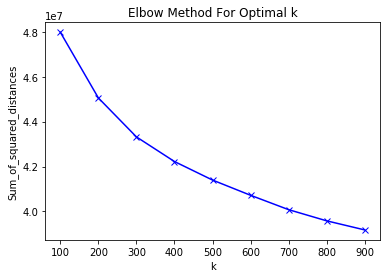

In [11]:
# Pour optimiser les temps de calculs, je procède à un kmeans mini batch.
# Le batch vaut 10 % de la liste des descripteur
batch_size = int(len(descriptor_list) * 0.1)
print(batch_size)

# Méthode visuelle
Sum_of_squared_distances = []
K = np.arange(100, 1000, 100)
for k in K:
    print(k)
    km = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    km = km.fit(descriptor_list)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plt.savefig('img/sift_elbow_kmeans_' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True)

In [13]:
k = 300
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
%time kmeans.fit(descriptor_list)

Wall time: 2min


MiniBatchKMeans(batch_size=58902, compute_labels=True, init=&#39;k-means++&#39;,
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=300, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [89]:
%time bovw_train = get_predict_sift(X_train, kmeans, k)
bovw_train

Wall time: 9min 26s


In [68]:
%time bovw_test = get_predict_sift(X_test, kmeans, k)
bovw_test

Wall time: 2min 48s


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.0,1.0,3.0,0.0,3.0,3.0,0.0,3.0,3.0,3.0,...,0.0,1.0,4.0,0.0,2.0,2.0,3.0,4.0,0.0,3.0
1,1.0,9.0,0.0,1.0,2.0,0.0,0.0,24.0,1.0,0.0,...,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0
2,3.0,6.0,1.0,3.0,4.0,1.0,3.0,3.0,4.0,3.0,...,2.0,3.0,0.0,2.0,0.0,3.0,4.0,6.0,3.0,2.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
4,2.0,7.0,1.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,...,1.0,2.0,0.0,2.0,3.0,0.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
228,0.0,3.0,7.0,1.0,2.0,0.0,8.0,1.0,4.0,0.0,...,2.0,0.0,5.0,1.0,5.0,0.0,0.0,1.0,3.0,2.0
229,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
230,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# 4. Classification

LogisticRegression en cours d&#39;exécution...
LinearSVC en cours d&#39;exécution...
SGD en cours d&#39;exécution...
RandomForest en cours d&#39;exécution...
GradientBoosting en cours d&#39;exécution...


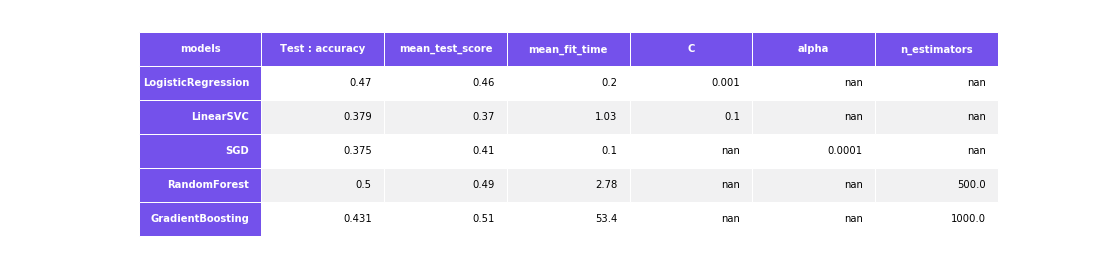

Wall time: 2min 43s


In [126]:
# To Do : Tester Random Forest et Gradient boosting
classifiers = [('LogisticRegression',
                LogisticRegression(),
                [{'C': [0.001, 0.1, 1]}]),

              ('LinearSVC',
               LinearSVC(),
               [{'C': [00.1, 0.1, 1]}]), 

              ('SGD',
               SGDClassifier(),
               [{'alpha': [10**-6, 10**-5, 10**-4]}]),
               
              ('RandomForest',
               RandomForestClassifier(random_state=123),
               [{'n_estimators': [200, 500, 1000]}]),

              ('GradientBoosting', 
               GradientBoostingClassifier(random_state=123), 
               [{'n_estimators': [200, 500, 1000]}])]

%time evaluate_classifier(bovw_train, bovw_test, y_train, y_test, classifiers, target_name='sift_' + str(size_image) + '_' + str(n_breeds) + '_breeds')

In [155]:
model = RandomForestClassifier(n_estimators=500, n_jobs=-1)
model.fit(bovw_train, y_train)
y_pred = model.predict(bovw_test)

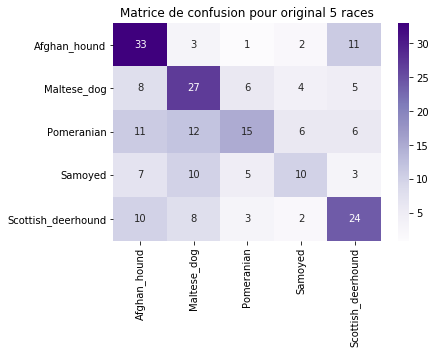

In [168]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Matrice de confusion pour ' + str(size_image) + ' ' + str(n_breeds) + ' races')
plt.savefig('img/sift_confusion_matrix' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True,
            bbox_inches="tight")

# Evaluation sur les images 220 px

In [ ]:
dogs = pd.read_csv('src/dogs.csv')
print(f'Nous avons {len(dogs)} photos de chiens comprenant {dogs.breeds.nunique()} races.')
n_breeds = 5
size_image = 'original'

top5breeds = dogs.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
top5breeds

dogs5 = pd.DataFrame()
for b in top5breeds:
    dogs5 = dogs5.append(dogs[dogs.breeds == b])

dogs5

le = LabelEncoder()
dogs5['encoding_breeds'] = le.fit_transform(dogs5.breeds)
dogs5

X_train, X_test, y_train, y_test = train_test_split(dogs5.uri, dogs5.encoding_breeds, test_size=0.2, random_state=42)

%time sifts = get_sifts_features(X_train)
%time test_bovw_features = get_sifts_features(X_test)[1] 
